In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, average_precision_score
from sklearn.datasets import make_classification

sns.set_palette('Spectral')

---

# <center> Custom Logistic Regression </center>

# L2 Regularization (Ridge) for Logistic Regression
<div class="notes-container">
  <div class="note-box">
    L2 regularization adds a penalty term proportional to the square of the magnitude of the coefficients.<br>
    This helps reduce overfitting by shrinking the weights.
    <div class="math-center">
      \( J(\mathbf{w}) = \underbrace{-\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)}) \right]}_{\text{Cross-Entropy Loss}} 
      + \underbrace{\frac{\lambda}{2m} \sum_{j=1}^n w_j^2}_{\text{L2 Regularization Term}} \)
    </div>
    <div class="note-description">
      where:
      <ul>
        <li><strong>m</strong>: number of training examples</li>
        <li><strong>n</strong>: number of features</li>
        <li><strong>\( \hat{y}^{(i)} \)</strong>: predicted probability for the <em>i</em>-th example</li>
        <li><strong>\( y^{(i)} \)</strong>: true binary label (0 or 1)</li>
        <li><strong>\( w_j \)</strong>: model weights</li>
        <li><strong>\( \lambda \)</strong>: regularization strength</li>
      </ul>
    </div>
    <hr style="margin: 25px 0; border: 1px solid #60a5fa;">
    <div class="note-description">
      <ul>
        <li>L2 regularization prevents weights from becoming too large.</li>
        <li>The first term is the standard logistic regression loss (cross-entropy).</li>
        <li>The second term penalizes large weights to reduce overfitting.</li>
      </ul>
    </div>
  </div>
</div>

In [96]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, number_of_epochs=1000,
                 regularization_strength=0.01, regularize=False, scale=False,
                 verbose=False, log_every=100):
        self.weights_vector = None                  # weights of features (coefficients). shape(n_features,)
        self.bias = None                            # bias (intercept)
        
        self.learning_rate = learning_rate          # learning rate
        self.number_of_epochs = number_of_epochs    # number of training epochs
        
        self.final_loss = None                      # last loss value of the model
        self.loss_history = []                      # all losses generated by the model
        
        self.regularize = regularize                # should the model add regularization
        self.regularization_strength = regularization_strength  # should the model regularize, how strong the regularization be
        
        self.scale = scale                          # should the model scale the data before fitting
        self.scaler = None                          # the scaler used to scale the model
        
        self.verbose = verbose                      # print epoch | cost | weights norm
        self.log_every = log_every                  # log how often 

    def _sigmoid(self, z):
        # Activation function to turn the output of the forward propogation (raw values - z) to a probability
        z = np.clip(z, -500, 500)  # Clipping to avoid overflow
        return 1 / (1 + np.exp(-z))
    
    def _log_loss(self, y, y_hat):
        # the cost function of a logistic regression
        epsilon = 1e-10
        mean_loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
        
        if self.regularize:
            l2_penalty = (self.regularization_strength / 2) * np.sum(self.weights_vector ** 2)
            return mean_loss + l2_penalty
        else:
            return mean_loss
    
    def _forward_propagation(self, X, y):
        z = X @ self.weights_vector + self.bias  # (n_samples x n_features) @ (n_features,) --> shape(n_samples,)
        y_hat = self._sigmoid(z)  # outputs probability for each row(sample) in X
        loss = self._log_loss(y, y_hat)
        self.loss_history.append(loss)
        
        return y_hat, loss

    def _back_propagation(self, X, y, y_hat):
        error = y_hat - y  # shape(n_samples,)
        bias_derivative = np.mean(error)  # bias not affected by regularization
        
        number_of_samples = X.shape[0]

        if self.regularize:
            weights_derivative = ( X.T @ error ) / number_of_samples + ( self.regularization_strength * self.weights_vector )  # shape(n_features,)
        else:
            weights_derivative = X.T @ (error) / number_of_samples
        
        return weights_derivative, bias_derivative 

    def _update(self, weights_derivative, bias_derivative):
        self.weights_vector = self.weights_vector - self.learning_rate * weights_derivative
        self.bias = self.bias - self.learning_rate * bias_derivative
        
    def fit(self, X, y):
        if self.scale:  # assumes the split happended before calling fit
            self.scaler = StandardScaler() 
            X = self.scaler.fit_transform(X)

        self.weights_vector = np.zeros(X.shape[1])  # shape(n_features,) because there's only one output per sample. If multiclass, then shape(n_features, k) where k is the number of classes
        self.bias = 0  # single value because there's only one output per sample. If multiclass, then shape(k, ), where k is the number of classes
        
        for epoch in range(self.number_of_epochs):
            y_hat, loss = self._forward_propagation(X, y)
            weights_derivative, bias_derivative = self._back_propagation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

            if self.verbose and (epoch % self.log_every == 0 or epoch == self.number_of_epochs - 1):
                # print(f'Epoch: {epoch} | Loss: {loss} | Weights Norm: {np.linalg.norm(self.weights_vector):.2f}')
                print(f"Epoch {epoch:<5} | Loss: {loss:.5f} | Weights Norm: {np.linalg.norm(self.weights_vector):.5f}")

        self.final_loss = loss
        
        return self
    
    def predict_probability(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        z = X @ self.weights_vector + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        probabilites = self.predict_probability(X)
        return (probabilites >= 0.5).astype(int)

    @staticmethod
    def inverse_transform(weights, bias, scaler):
        """
        Recover coefficients and intercept in the original feature scale
        if the input data was standardized with a scaler.

        Parameters
        ----------
        weights : np.ndarray
            Weights from the trained model (on scaled data).
        bias : float
            Bias term from the trained model (on scaled data).
        scaler : fitted sklearn.preprocessing.StandardScaler
            The scaler used to standardize the original features.

        Returns
        -------
        original_weights : np.ndarray
            Coefficients in the original scale.
        original_bias : float
            Intercept in the original scale.
        """
        stds = scaler.scale_
        means = scaler.mean_
        original_weights = weights / stds
        original_bias = bias - np.sum(weights * means / stds)
        return original_weights, original_bias

    def plot_losses(self, ax=None):
        '''
            Plot losses over the epochs as the model is training
        '''

        if ax is None:
            ax = plt.gca()

        ax.plot(self.loss_history, label=f'Final loss: {self.final_loss:.2f}')
        
        ax.set_xlabel('Epochs', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        ax.grid(alpha=0.5)



# <center> Compare CustomLogisticRegression with Sklearn Logistic Regression

#### 1. Generate synthetic data

In [97]:
features_synthetic, target_synthetic = make_classification(n_samples=30000,
                                                           n_features=15,  
                                                           n_informative=10,
                                                           n_classes=2,
                                                           random_state=42,
                                                           shift=5)

#### 2. Split the data

In [98]:
X_train, X_test, y_train, y_test = train_test_split(features_synthetic,
                                                    target_synthetic,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

#### 3. Fit and predict with the model

In [99]:
custom_log_reg = CustomLogisticRegression(verbose=False, regularize=True, number_of_epochs=1000, learning_rate=0.01, regularization_strength=0.05).fit(X_train, y_train)
custom_predictions = custom_log_reg.predict(X_test)
custom_probabilities = custom_log_reg.predict_probability(X_test)

#### 4. Evaluation plots

In [100]:
import sys
sys.path.append('../')

from my_utils.classification_eval_plots import ClassificationEvaluationPlots

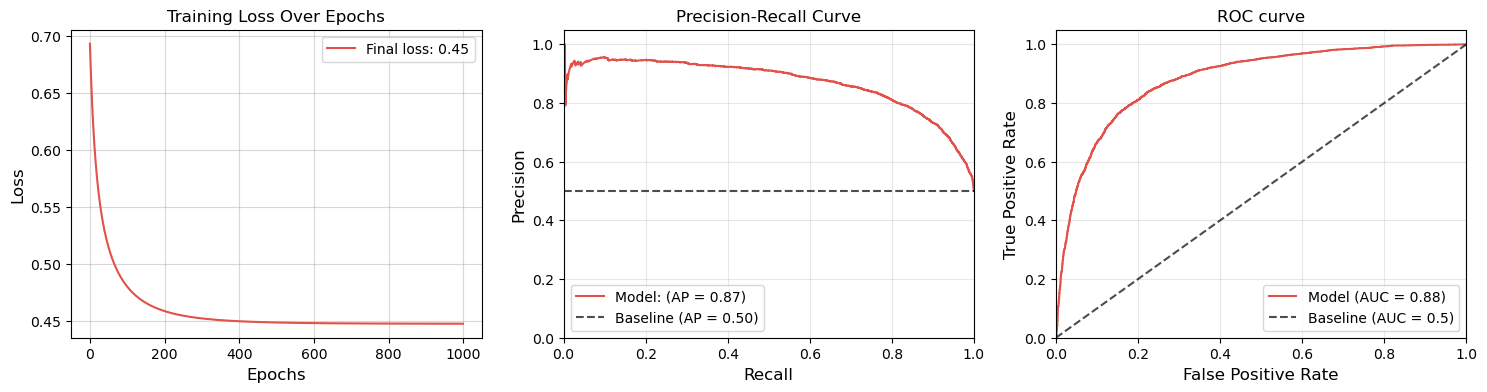

In [101]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
custom_log_reg.plot_losses(ax=axes[0])
ClassificationEvaluationPlots.plot_precision_recall_curve(y_test, custom_probabilities, ax=axes[1])
ClassificationEvaluationPlots.plot_roc_curve(y_test, custom_probabilities, ax=axes[2])

#### 5. Fit and predict with sklearn logistic regression

In [102]:
sklearn_log_reg = LogisticRegression().fit(X_train, y_train)
sklearn_predictions = sklearn_log_reg.predict(X_test)
sklearn_probabilities = sklearn_log_reg.predict_proba(X_test)

#### 6. Evaluation plots

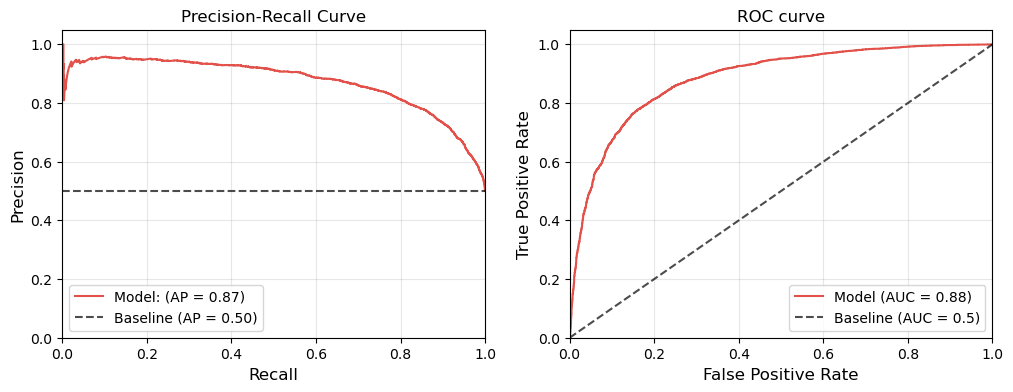

In [103]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ClassificationEvaluationPlots.plot_precision_recall_curve(y_test, sklearn_probabilities[:, 1], ax=axes[0])
ClassificationEvaluationPlots.plot_roc_curve(y_test, sklearn_probabilities[:, 1], ax=axes[1])

# <center> Compare scores </center>

<Axes: >

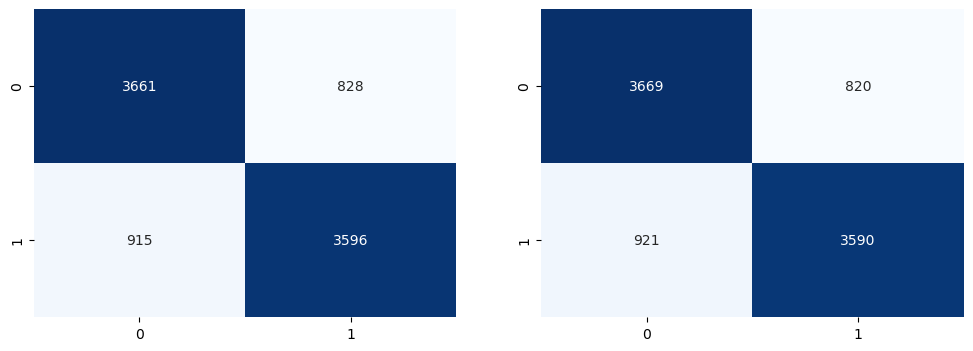

In [104]:
from sklearn.metrics import recall_score, precision_score

custom_accuracy = accuracy_score(y_test, custom_predictions)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)

custom_recall = recall_score(y_test, custom_predictions)
sklearn_recall = recall_score(y_test, sklearn_predictions)

custom_precision = precision_score(y_test, custom_predictions)
sklearn_precision = precision_score(y_test, sklearn_predictions)

custom_f1 = f1_score(y_test, custom_predictions)
sklearn_f1 = f1_score(y_test, sklearn_predictions)

figure, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(confusion_matrix(y_test, custom_predictions), annot=True, cbar=False, cmap='Blues', fmt='0g', ax=axes[0])
sns.heatmap(confusion_matrix(y_test, sklearn_predictions), annot=True, cbar=False, cmap='Blues', fmt='0g', ax=axes[1])

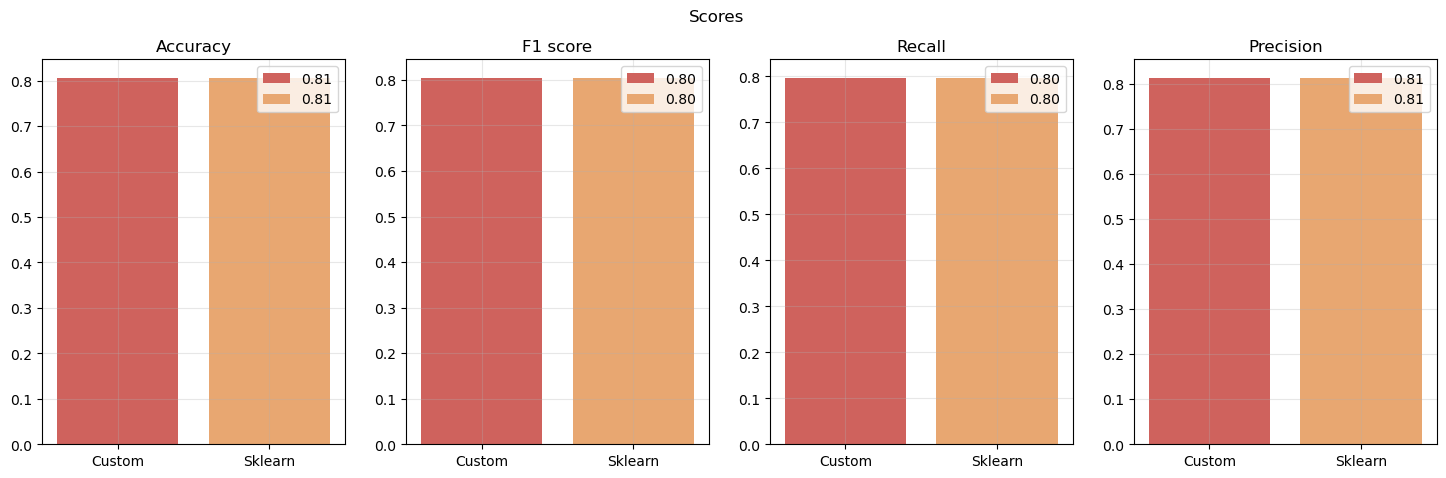

In [105]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

sns.barplot(x=['Custom'], y=custom_accuracy, label=f'{custom_accuracy:.2f}', ax=ax[0])
sns.barplot(x=['Sklearn'], y=sklearn_accuracy, label=f'{sklearn_accuracy:.2f}',ax=ax[0])


sns.barplot(x=['Custom'], y=custom_f1, label=f'{custom_f1:.2f}', ax=ax[1])
sns.barplot(x=['Sklearn'], y=sklearn_f1, label=f'{sklearn_f1:.2f}',ax=ax[1])


sns.barplot(x=['Custom'], y=custom_recall, label=f'{custom_recall:.2f}', ax=ax[2])
sns.barplot(x=['Sklearn'], y=sklearn_recall, label=f'{sklearn_recall:.2f}',ax=ax[2])


sns.barplot(x=['Custom'], y=custom_precision, label=f'{custom_precision:.2f}', ax=ax[3])
sns.barplot(x=['Sklearn'], y=sklearn_precision, label=f'{sklearn_precision:.2f}',ax=ax[3])


fig.suptitle('Scores')

ax[0].grid(alpha=0.3); ax[0].set_title('Accuracy')
ax[1].grid(alpha=0.3); ax[1].set_title('F1 score')
ax[2].grid(alpha=0.3); ax[2].set_title('Recall')
ax[3].grid(alpha=0.3); ax[3].set_title('Precision');

<hr color='orange'>
<hr color='orange'>
<hr color='orange'>

In [106]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
features = data.data
target = data.target

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)


custom_log_reg2 = CustomLogisticRegression(verbose=True, log_every=500,
                                           regularize=True, regularization_strength=0.1,
                                           number_of_epochs=10000, learning_rate=0.00001).fit(X_train, y_train)
custom_predictions2 = custom_log_reg2.predict(X_test)
custom_probabilities2 = custom_log_reg2.predict_probability(X_test)

Epoch 0     | Loss: 0.69315 | Weights Norm: 0.00094
Epoch 500   | Loss: 0.31586 | Weights Norm: 0.03825
Epoch 1000  | Loss: 0.27842 | Weights Norm: 0.05116
Epoch 1500  | Loss: 0.26275 | Weights Norm: 0.05955
Epoch 2000  | Loss: 0.25419 | Weights Norm: 0.06573
Epoch 2500  | Loss: 0.24887 | Weights Norm: 0.07056
Epoch 3000  | Loss: 0.24527 | Weights Norm: 0.07448
Epoch 3500  | Loss: 0.24265 | Weights Norm: 0.07776
Epoch 4000  | Loss: 0.24065 | Weights Norm: 0.08055
Epoch 4500  | Loss: 0.23905 | Weights Norm: 0.08297
Epoch 5000  | Loss: 0.23772 | Weights Norm: 0.08510
Epoch 5500  | Loss: 0.23657 | Weights Norm: 0.08701
Epoch 6000  | Loss: 0.23556 | Weights Norm: 0.08873
Epoch 6500  | Loss: 0.23466 | Weights Norm: 0.09030
Epoch 7000  | Loss: 0.23383 | Weights Norm: 0.09175
Epoch 7500  | Loss: 0.23306 | Weights Norm: 0.09311
Epoch 8000  | Loss: 0.23234 | Weights Norm: 0.09438
Epoch 8500  | Loss: 0.23166 | Weights Norm: 0.09559
Epoch 9000  | Loss: 0.23102 | Weights Norm: 0.09674
Epoch 9500  

In [107]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

custom_log_reg3 = CustomLogisticRegression(verbose=True, log_every=10,
                                           regularize=True,  regularization_strength=0.01,
                                           number_of_epochs=100, learning_rate=1).fit(X_train_scaled, y_train)
custom_predictions3 = custom_log_reg3.predict(X_test_scaled)
custom_probabilities3 = custom_log_reg3.predict_probability(X_test_scaled)

Epoch 0     | Loss: 0.69315 | Weights Norm: 1.38936
Epoch 10    | Loss: 0.11957 | Weights Norm: 1.70084
Epoch 20    | Loss: 0.11170 | Weights Norm: 1.89932
Epoch 30    | Loss: 0.10868 | Weights Norm: 2.02135
Epoch 40    | Loss: 0.10719 | Weights Norm: 2.10310
Epoch 50    | Loss: 0.10635 | Weights Norm: 2.16092
Epoch 60    | Loss: 0.10583 | Weights Norm: 2.20341
Epoch 70    | Loss: 0.10549 | Weights Norm: 2.23557
Epoch 80    | Loss: 0.10527 | Weights Norm: 2.26048
Epoch 90    | Loss: 0.10511 | Weights Norm: 2.28012
Epoch 99    | Loss: 0.10502 | Weights Norm: 2.29442


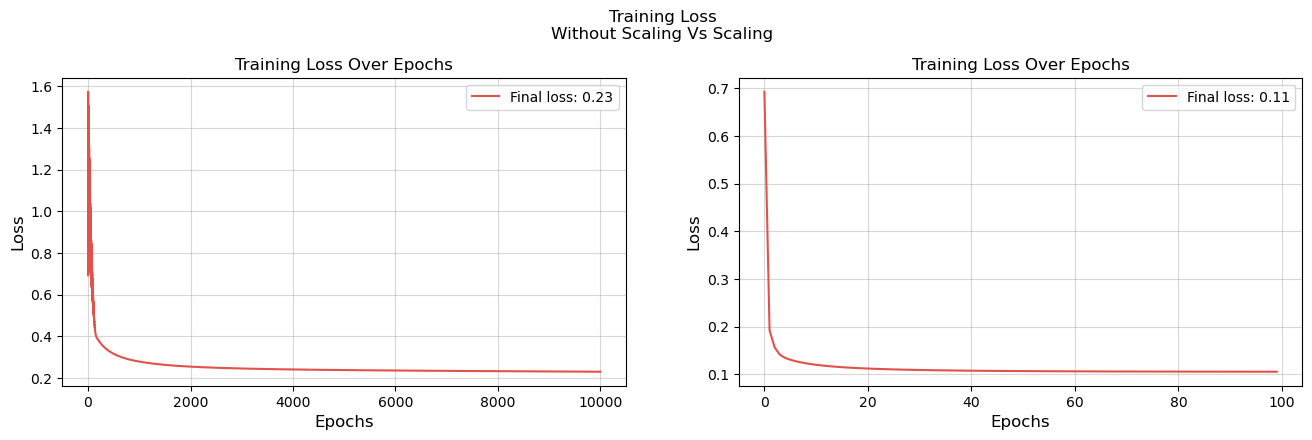

In [108]:
figure, axes = plt.subplots(1, 2, figsize=(16, 4))
figure.suptitle('Training Loss\nWithout Scaling Vs Scaling', y=1.05)

custom_log_reg2.plot_losses(ax=axes[0])
custom_log_reg3.plot_losses(ax=axes[1])

In [109]:
sklearn_log_reg_2 = LogisticRegression().fit(X_train_scaled, y_train)
sklearn_predictions_2 = sklearn_log_reg_2.predict(X_test_scaled)

In [110]:
from sklearn.metrics import recall_score, precision_score

custom_accuracy_2 = accuracy_score(y_test, custom_predictions3)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions_2)

custom_recall_2 = recall_score(y_test, custom_predictions3)
sklearn_recall = recall_score(y_test, sklearn_predictions_2)

custom_precision_2 = precision_score(y_test, custom_predictions3)
sklearn_precision = precision_score(y_test, sklearn_predictions_2)

custom_f1_2 = f1_score(y_test, custom_predictions3)
sklearn_f1 = f1_score(y_test, sklearn_predictions_2)

# sns.heatmap(confusion_matrix(y_test, sklearn_predictions_2), annot=True, cbar=False, cmap='Blues', fmt='0g')

(0.0, 1.1)

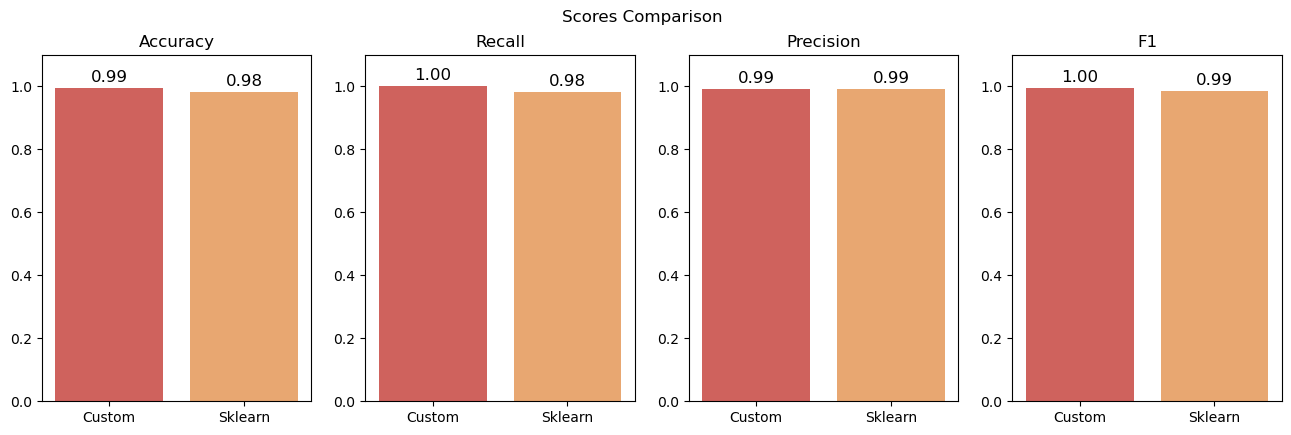

In [111]:
figure, axes = plt.subplots(1, 4, figsize=(16, 4.5))
figure.suptitle('Scores Comparison')

# ------------------------------- Accuracy ----------------------------------------

sns.barplot(x=['Custom'], y=custom_accuracy_2, ax=axes[0])
sns.barplot(x=['Sklearn'], y=sklearn_accuracy, ax=axes[0])

# Add value labels on top of bars
for i, score in enumerate([custom_accuracy_2, sklearn_accuracy]):
    axes[0].text(i, score + 0.01, f'{score:.2f}', 
            ha='center', va='bottom', fontsize=12)

axes[0].set_title('Accuracy')
axes[0].set_ylim([0.0, 1.1])

# ------------------------------- Recall ----------------------------------------

sns.barplot(x=['Custom'], y=custom_recall_2, ax=axes[1])
sns.barplot(x=['Sklearn'], y= sklearn_recall, ax=axes[1])

# Add value labels on top of bars
for i, score in enumerate([custom_recall_2, sklearn_recall]):
    axes[1].text(i, score + 0.01, f'{score:.2f}', 
            ha='center', va='bottom', fontsize=12)

axes[1].set_title('Recall')
axes[1].set_ylim([0.0, 1.1])

# ----------------------------- Precision ------------------------------------------

sns.barplot(x=['Custom'], y=custom_precision_2, ax=axes[2])
sns.barplot(x=['Sklearn'], y= sklearn_precision, ax=axes[2])

# Add value labels on top of bars
for i, score in enumerate([custom_precision_2, sklearn_precision]):
    axes[2].text(i, score + 0.01, f'{score:.2f}', 
            ha='center', va='bottom', fontsize=12)

axes[2].set_title('Precision')
axes[2].set_ylim([0.0, 1.1])

# --------------------------- F1 score --------------------------------------------

sns.barplot(x=['Custom'], y=custom_f1_2, ax=axes[3])
sns.barplot(x=['Sklearn'], y= sklearn_f1, ax=axes[3])

# Add value labels on top of bars
for i, score in enumerate([custom_f1_2, sklearn_f1]):
    axes[3].text(i, score + 0.01, f'{score:.2f}', 
            ha='center', va='bottom', fontsize=12)

axes[3].set_title('F1')
axes[3].set_ylim([0.0, 1.1])